# Final Project: Prediction of Cardiovascular Disease

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# read in cardiovascular data
cardio = pd.read_csv('cardio_train.csv', delimiter = ';', usecols = ['id','age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio'])
cardio.loc[:,"delete"] = np.zeros(cardio.shape[0])
cardio.loc[cardio["ap_lo"] > 500, "delete"] = 1
cardio.loc[cardio["ap_lo"] < 30, "delete"] = 1
cardio.loc[cardio["ap_hi"] < 30, "delete"] = 1
cardio.loc[cardio["ap_hi"] > 500, "delete"] = 1
cardio.loc[cardio["height"] < 121, "delete"] = 1
cardio.loc[cardio["height"] > 230, "delete"] = 1
cardio = cardio.loc[cardio["delete"].isin([0]),:]
cardio = cardio.drop(columns = ["delete"])
cardio.drop(columns = ['id'])
aplo = cardio["ap_lo"].to_numpy()
aplo = set(list(aplo))


cardio.loc[cardio["ap_lo"].isin([0]),:]
cardio.drop(columns = ['id'])

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,22431,1,163,72.0,135,80,1,2,0,0,0,1


https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [2]:
data = cardio.to_numpy()[:,1:]

In [3]:
X = data[:,:-1]
Y = data[:,-1]

In [4]:
cardio1 = cardio.loc[cardio["cardio"].isin([1]),:]
cardio0 = cardio.loc[cardio["cardio"].isin([0]),:]
count_cardio1 = cardio1.shape[0]
count_cardio0 = cardio0.shape[0]

## Implementation and Visualization of PLSR

In [5]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score

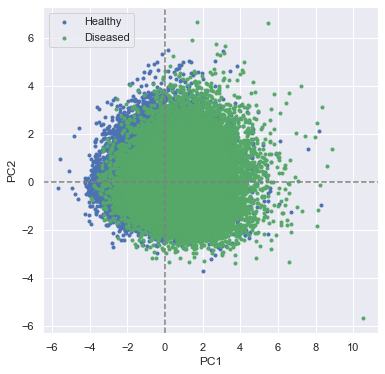

0.7244938063145024


In [6]:
PLSR = PLSRegression(n_components=2)
x_scores, y_scores = PLSR.fit_transform(X,Y)

xdata, ydata = x_scores[:,0].reshape((-1,1)), x_scores[:,1].reshape((-1,1))
plt.figure(figsize = (6,6))
plt.scatter(xdata[Y == 0], ydata[Y == 0], color = 'b', marker =  '.', label = 'Healthy')
plt.scatter(xdata[Y == 1], ydata[Y == 1], color = 'g', marker = '.', label = 'Diseased')
plt.legend(loc = 'upper left')
plt.axvline(color =  'gray', linestyle = 'dashed')
plt.axhline(color =  'gray', linestyle = 'dashed')
plt.xlabel("PC1"), plt.ylabel('PC2')
plt.show()

predicted = PLSR.predict(X)
predicted[predicted < np.mean(predicted)] = 0
predicted[predicted > np.mean(predicted)] = 1

print(accuracy_score(Y.flatten(),predicted))


In [7]:
# 10-fold cross-validation
from sklearn.model_selection import KFold
predPLSRcv, mean_cutoff, med_cutoff = np.zeros((3,cardio.shape[0]))
kf = KFold(n_splits = 10)
for train, test in kf.split(X):
    PLSR = PLSRegression(n_components=2)
    x_scores, y_scores = PLSR.fit_transform(X[train],Y[train])
    predPLSRcv[test] = np.squeeze(PLSR.predict(X[test]))
median = np.median(predPLSRcv)
mean = np.mean(predPLSRcv)
mean_cutoff[predPLSRcv > mean] = 1
med_cutoff[predPLSRcv > median] = 1
predPLSRcv = np.round(predPLSRcv)

#print information
cutoff_type = ['Round', 'Mean', 'Median']
cutoff_val = [0.5, mean, median]
accuracies = [accuracy_score(Y.flatten(),predPLSRcv), accuracy_score(Y.flatten(),mean_cutoff), accuracy_score(Y.flatten(),med_cutoff)]
dat = [cutoff_val, accuracies]
df = pd.DataFrame(dat, index = ['Value of Cutoff', 'Accuracy'], columns = cutoff_type)
df.round(4)

,Round,Mean,Median
Value of Cutoff,0.5000,0.4949,0.4670
Accuracy,0.7234,0.7246,0.7227


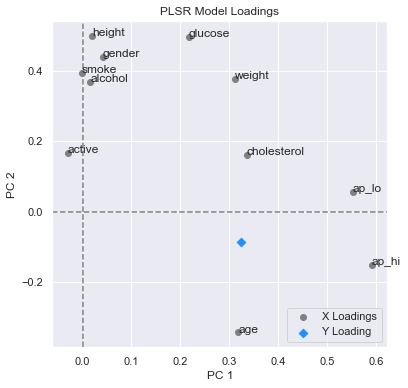

In [8]:
yload, xload = PLSR.y_loadings_, PLSR.x_loadings_

plt.figure(figsize = (6,6))
plt.scatter(xload[:,0], xload[:,1], color = 'gray', label = 'X Loadings')
plt.scatter(yload[:,0], yload[:,1], color = 'dodgerblue', marker = 'D', label = 'Y Loading')

plt.axhline(y=0,color = 'gray', linestyle='--'), plt.axvline(x=0, color = 'gray',linestyle='--')
#plt.scatter(xload[i:i+j,0], xload[i:i+j,1], color = 'r')
#plt.axis([-6,8,-4,7])
vars = ['age','gender','height','weight','ap_hi','ap_lo','cholesterol','glucose','smoke','alcohol','active']
for i in range(xload.shape[0]):
    plt.text(xload[i,0], xload[i,1], vars[i])
plt.xlabel('PC 1'), plt.ylabel('PC 2')
plt.legend(loc = 'lower right')
plt.title('PLSR Model Loadings')
plt.show()

### PCA Visualization

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

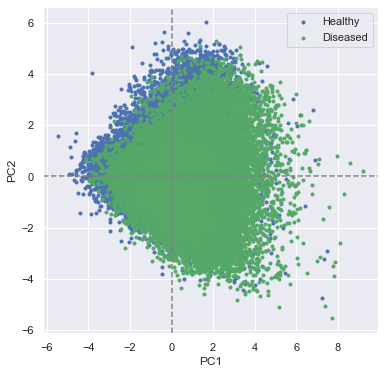

In [10]:
X_scale = scale(X)
pca = PCA(n_components = 2)
X_r  = pca.fit_transform(X_scale)
plt.figure(figsize = (6,6))
plt.axvline(color =  'gray', linestyle = 'dashed')
plt.axhline(color =  'gray', linestyle = 'dashed')
plt.scatter(X_r[Y == 0, 0], X_r[Y == 0, 1], marker = '.',color =  'b', label = 'Healthy')
plt.scatter(X_r[Y == 1, 0], X_r[Y == 1, 1], marker = '.', color =  'g', label = 'Diseased')
plt.legend(loc = 'upper right')
plt.xlabel('PC1'), plt.ylabel('PC2')
plt.show()

## Logistic Regression Implementation

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
X = data[:,:-1]
Y = data[:,-1]
Xactive = data[:,-2:-1]
Xobj = data[:,:-4] # Removing the Subjective Information

Xmatrix = [X,Xobj,Xactive]


In [13]:
for matrix in Xmatrix:
    logreg = LogisticRegression()
    logreg.fit(matrix,Y)
    predicted_classes = logreg.predict(matrix)
    accuracy = accuracy_score(Y.flatten(),predicted_classes)
    parameters = logreg.coef_
    print(accuracy)



0.7020480647462117
0.7020771772514883
0.5178969126188154


### Try cross-validation

In [14]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings("ignore")

In [15]:
logreg2 = LogisticRegressionCV()
logreg2.fit(X,Y)
predicted_classes = logreg2.predict(X)
accuracy = accuracy_score(Y.flatten(),predicted_classes)
parameters = logreg2.coef_
print(accuracy)

0.7106216975501827


#### Try sets of data

In [16]:
Xactive = data[:,-2:-1]
Xobj = data[:,0:4] # Removing the Subjective Information
Xeval = data[:,4:8]
Xsub = data[:,8:11]
Xnosub = np.concatenate((Xobj,Xeval),axis = 1)
Xnoeval = np.concatenate((Xobj,Xsub),axis = 1)
Xnoobj = np.concatenate((Xeval,Xsub),axis = 1)

Xmatrix = [X,Xobj,Xeval,Xsub,Xnosub,Xnoeval,Xnoobj]

names = ['All','Obj', 'Eval', 'Sub', 'Obj + Eval', 'Obj + Sub', 'Eval + Sub']

scores = np.zeros((1,7))
for count, matrix in enumerate(Xmatrix):
    logreg = LogisticRegressionCV()
    logreg.fit(matrix,Y)
    predicted_classes = logreg.predict(matrix)
    if(count == 0):
        y_predROC = np.copy(predicted_classes)
        Y_ROC = np.copy(Y)        
    accuracy = accuracy_score(Y.flatten(),predicted_classes)
    parameters = logreg.coef_
    scores[0,count] = accuracy

df = pd.DataFrame(scores, columns = names, index = ['score'])
df

,All,Obj,Eval,Sub,Obj + Eval,Obj + Sub,Eval + Sub
score,0.710622,0.620431,0.722369,0.517897,0.7056,0.620562,0.723955


[0.7645266635500862, 0.7730895010648176, 0.5145427099335481]


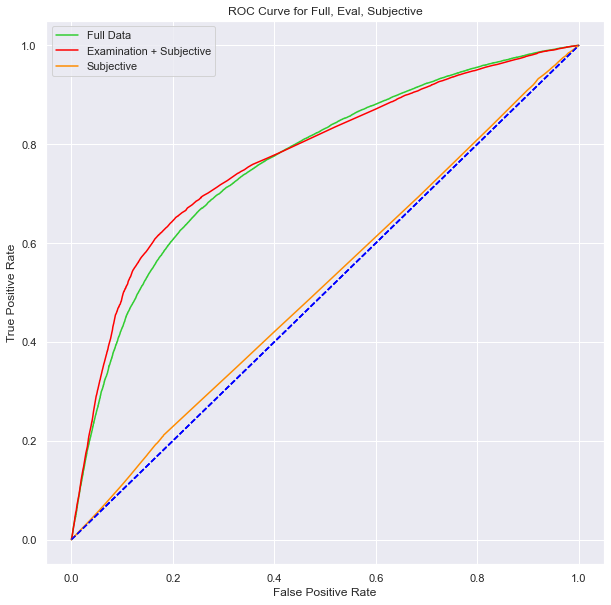

In [17]:
Xmatrix = [X,Xobj,Xeval,Xsub,Xnosub,Xnoeval,Xnoobj]

def log_reg(X,Y):

    y_predict = np.zeros(len(Y))
    y_prob = np.zeros(len(Y))
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    y_score = []
    val = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for train_index, test_index in skf.split(X, Y):
        train_X = X[train_index]
        train_Y = Y[train_index]
        test_X = X[test_index]
        test_Y = Y[test_index]

        logreg = LogisticRegressionCV()
        logreg.fit(train_X, train_Y)

        y_predict = logreg.predict(test_X)
        y_score.append(logreg.score(test_X, test_Y))
        lr_prob = logreg.predict_proba(test_X)
        lr_prob = lr_prob[:, 1]
        for i in range(len(test_index)):
            y_prob[test_index[i]] = lr_prob[i]
    return y_predict,y_score,y_prob

XROCMatrix = [X,Xnoobj,Xsub]
names = ["Full Data", "Examination + Subjective","Subjective" ]
color = ['limegreen', 'red', 'darkorange']
auc_score = []
plt.figure(figsize = (10,10))

for count, matrix in enumerate(XROCMatrix):
    _,_,y_predROC = log_reg(matrix,Y)
    fpr, tpr, _ = roc_curve(Y_ROC,y_predROC)
    title = 'Full, Eval, Subjective'
    auc_score.append(roc_auc_score(Y_ROC,y_predROC))
    x = np.linspace(0,1,num = 10)
    plt.plot(fpr, tpr, color = color[count], label = names[count])
    plt.plot(x,x,color = 'blue', linestyle = 'dashed')
    plt.title("ROC Curve for " + title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()


print(auc_score)
    

#### Try one variable at a time

In [18]:
scores = np.zeros((1,11))
for i in range(11):
    smallX =  X[:,i:i+1]
    logreg2.fit(smallX,Y)
    predicted_classes = logreg2.predict(smallX)
    accuracy = accuracy_score(Y.flatten(),predicted_classes)
    scores[0,i] = accuracy
names = ['age','gender','height','weight','SBP','DBP','cholesterol','gluc','smoke','alco','active']
df = pd.DataFrame(scores, columns = names, index = ['score'])
df

,age,gender,height,weight,SBP,DBP,cholesterol,gluc,smoke,alco,active
score,0.494942,0.505058,0.505058,0.575598,0.712325,0.659093,0.591493,0.536209,0.505058,0.505058,0.517897


### SVM

In [19]:
from sklearn.svm import SVC # "Support vector classifier"

In [20]:
from time import time

In [21]:
subX = X[0:1000, :]
subY = Y[0:1000]
testX = X[500:1000,:]
testY= Y[500:1000]

In [22]:
accuracyList = []
scoreList = []
for i in range(1,68):
    subX = X[(i-1)*1000:i*1000,:]
    subY = Y[(i-1)*1000:i*1000]
    model = SVC(kernel = 'linear', C = 1)
    model.fit(subX, subY)
    predicted = model.predict(X)
    tic = time()
    accuracy = accuracy_score(Y.flatten(),predicted)
    accuracyList.append(accuracy)
    score = model.score(X,Y)
    scoreList.append(score)
    #print(tic-toc)
print("Accuracy List: " + str(accuracyList))
print("Score List: " + str(scoreList))

Accuracy List: [0.7234020873666284, 0.7157891672367865, 0.7218882370922429, 0.7104470225185229, 0.7186858615118124, 0.7211313119550503, 0.7237659936825863, 0.7166188736371708, 0.7189187615540256, 0.7200541492598146, 0.7194282303963667, 0.7239552249668846, 0.7151778046259771, 0.7176086988165766, 0.713358273046187, 0.722616049724159, 0.7243628000407575, 0.7256437502729297, 0.7203307180599426, 0.7229653997874788, 0.7197921367123248, 0.7186276365012592, 0.7220920246291794, 0.721931905850158, 0.7181181676589179, 0.723067293555947, 0.7111311663925239, 0.7097628786445217, 0.7253526252201633, 0.7203598305652192, 0.7206072868600707, 0.7174776925428318, 0.7232565248402452, 0.7151923608786154, 0.7216844495553065, 0.7246684813461622, 0.716764436163554, 0.7190060990698555, 0.7254399627359932, 0.7173466862690869, 0.7214515495130933, 0.718351067701131, 0.7210003056813054, 0.716764436163554, 0.7165897611318942, 0.7220337996186261, 0.721524330776285, 0.7240280062300761, 0.7202288242914744, 0.7249013813

In [23]:
print(max(accuracyList))
print(max(scoreList))

0.7256437502729297
0.7256437502729297


In [24]:
model = SVC(kernel = 'rbf', C = 16237767)
model.fit(subX, subY)
predicted = model.predict(X)
accuracy = accuracy_score(Y.flatten(),predicted)
print("RBF accuracy score with C = 16237767 and default gamma: " + str(accuracy))
print("Scaled gamma value: " + str(1/(11*X.var())))

RBF accuracy score with C = 16237767 and default gamma: 0.723067293555947
Scaled gamma value: 2.8655643137790294e-09


In [25]:
a = 10
b = 10
cee = np.logspace(3,10,a, endpoint=True)
gamma = np.linspace(2E-9,4E-9,b)
scores = np.zeros((a,b))
for i,c in enumerate(cee):
    for j, gam in enumerate(gamma):
        model = SVC(kernel = 'rbf', C = c, gamma = gam)
        model.fit(subX, subY)
        predicted = model.predict(X)
        accuracy = accuracy_score(Y.flatten(),predicted)
        scores[i,j] = accuracy

array([[0.64702543, 0.65212012, 0.65469657, 0.65928179, 0.66341577,
        0.66530808, 0.66708395, 0.67016987, 0.67329947, 0.67677841],
       [0.70698263, 0.70688074, 0.70816169, 0.71084004, 0.71102927,
        0.71094194, 0.71200454, 0.71245579, 0.71241212, 0.71344561],
       [0.71568727, 0.71600751, 0.71648787, 0.71641509, 0.71664799,
        0.71651698, 0.71705556, 0.71741947, 0.71733213, 0.7176087 ],
       [0.71987947, 0.71925356, 0.72035983, 0.72031616, 0.72094208,
        0.71995226, 0.72091297, 0.7211022 , 0.72117498, 0.72166989],
       [0.72337297, 0.72414446, 0.72420268, 0.72302362, 0.72533807,
        0.7250615 , 0.723897  , 0.72344576, 0.72490138, 0.72497416],
       [0.72554186, 0.72185912, 0.72442103, 0.72049084, 0.72238315,
        0.72373688, 0.72265972, 0.72462481, 0.72347487, 0.726226  ],
       [0.72238315, 0.72181546, 0.72009782, 0.72281984, 0.71795805,
        0.72539629, 0.72322741, 0.72392611, 0.72172812, 0.7183074 ],
       [0.72581843, 0.72081107, 0.7221648

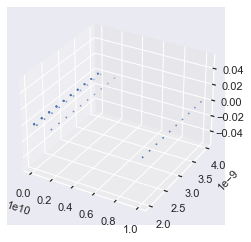

In [26]:
plt.axes(projection = '3d')
plt.scatter(np.repeat(cee,a),np.tile(gamma,b),scores.flatten())
scores

In [27]:
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold


subX = X[0:1000, :]
subY = Y[0:1000]
testX = X[500:1000,:]
testY= Y[500:1000]

model = SVC(kernel = 'rbf', C = 5.61E7, gamma = 3.7E-9)
model.fit(subX, subY)
predicted = model.predict(X)
accuracy = accuracy_score(Y.flatten(),predicted)
print(accuracy)

score1 = []
skf = StratifiedKFold(n_splits = 5, shuffle = True)
for train_index, test_index in skf.split(subX, subY):
    train_X, test_X = subX[train_index], subX[test_index]
    train_Y, test_Y = subY[train_index], subY[test_index]
    model1 = SVC(kernel = "rbf", C = 5.61E7, gamma = 3.7E-9)
    model1.fit(train_X,train_Y)
    score1.append(model1.score(test_X, test_Y))

print(score1)

0.7219610183554346
[0.76, 0.73, 0.755, 0.685, 0.725]


In [28]:
print(np.max(np.all(scores)))

True


In [29]:
from sklearn.metrics import plot_roc_curve

LINEAR DECISION BOUNDARY

In [30]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
%matplotlib inline

X = data[:,:-1]
Y = data[:,-1]

subX = X[0:1000, :]
subY = Y[0:1000]
testX = X[500:1000,:]
testY= Y[500:1000]

index = np.arange(0,subX.shape[0])
index = np.reshape(index,(1000,1))

subX = np.append(subX,index,1)


999.0


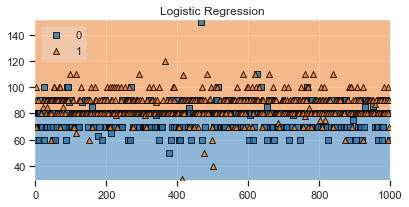

In [31]:
XLDB = subX[:,np.r_[11,5]]
print(np.max(XLDB))
yLDB = subY.astype(int)


clfLR = LogisticRegression()
gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(14,10))
labels = ['Logistic Regression']
for clf,lab,grd in zip([clfLR],labels,[(0,0)]):
    clf.fit(XLDB,yLDB)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=XLDB, y=yLDB, clf=clf, legend=2)
    plt.title(lab)
    plt.show()
